## This notebook shows how to use Orchestrator APIs for user experiments

In [1]:
import os
from fabric_cm.credmgr.credmgr_proxy import CredmgrProxy
from fabric_cf.orchestrator.orchestrator_proxy import OrchestratorProxy
import json

In [2]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
credmgr_proxy = CredmgrProxy(credmgr_host=credmgr_host)
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
orchestrator_proxy = OrchestratorProxy(orchestrator_host=orchestrator_host)

### Fabric Tokens
Fabric has 2 kinds of tokens:<br>
- Identity : required for Control/Measurement Framework APIs. Identity Token is valid upto an hour.
- Refresh : required to generate new Identity Tokens valid. Refresh Token is valid for 24 hours.

Fabric Identity token is required for Control/Measurement Framework APIs.<br>

When user logins to Jupyterhub after authenticating against CILogon, OIDC refresh token is derived. <br>
This token is available as the environment variable `CILOGON_REFRESH_TOKEN`.<br>

On the first login, we use `CILOGON_REFRESH_TOKEN` to generate new Fabric Identity Token and Fabric Refresh Token.<br>
For any subsequent use, we use Fabric Refresh Token. On every refresh, Fabric Refresh Token is changed and updated.<br>

NOTE: These steps are required for any experiments on Fabric Testbed.<br>

In [3]:
not_found=False
fabric_refresh_token=None
%store -r fabric_refresh_token

if fabric_refresh_token is None:
    fabric_refresh_token=os.environ['CILOGON_REFRESH_TOKEN']
    %store fabric_refresh_token
print("Fabric Refresh Token {}".format(fabric_refresh_token))
print("CILOGON_REFRESH_TOKEN environment variable: {}".format(os.environ['CILOGON_REFRESH_TOKEN']))

no stored variable or alias fabric_refresh_token
Stored 'fabric_refresh_token' (str)
Fabric Refresh Token https://cilogon.org/oauth2/refreshToken/46cd03360c7d14dd2b4f028a4143df1e/1616077005258
CILOGON_REFRESH_TOKEN environment variable: https://cilogon.org/oauth2/refreshToken/46cd03360c7d14dd2b4f028a4143df1e/1616077005258


### Get new Fabric Identity Token and update Fabric Refresh Token

Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [4]:
try:
    refresh_res = credmgr_proxy.refresh(project_name='all', scope='all', refresh_token=fabric_refresh_token)
    print("New Tokens received: {}".format(json.dumps(refresh_res)))
    fabric_id_token=refresh_res['id_token']
    fabric_refresh_token=refresh_res['refresh_token']
    print()
    print("New Refresh Token: {}".format(fabric_refresh_token))
    print()
    print("Stored new Refresh Token")
    %store fabric_refresh_token
except Exception as e:
    print("Exception occurred while getting tokens:{}".format(e))

New Tokens received: {"id_token": "eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsImtpZCI6ImI0MTUxNjcyMTExOTFlMmUwNWIyMmI1NGIxZDNiNzY2N2U3NjRhNzQ3NzIyMTg1ZTcyMmU1MmUxNDZmZTQzYWEifQ.eyJlbWFpbCI6Imt0aGFyZTEwQGVtYWlsLnVuYy5lZHUiLCJjZXJ0X3N1YmplY3RfZG4iOiIvREM9b3JnL0RDPWNpbG9nb24vQz1VUy9PPVVuaXZlcnNpdHkgb2YgTm9ydGggQ2Fyb2xpbmEgYXQgQ2hhcGVsIEhpbGwvQ049S29tYWwgVGhhcmVqYSBBMTE5MDQxMDYiLCJpZHAiOiJ1cm46bWFjZTppbmNvbW1vbjp1bmMuZWR1IiwiaWRwX25hbWUiOiJVbml2ZXJzaXR5IG9mIE5vcnRoIENhcm9saW5hIGF0IENoYXBlbCBIaWxsIiwiZXBwbiI6Imt0aGFyZTEwQHVuYy5lZHUiLCJhZmZpbGlhdGlvbiI6ImVtcGxveWVlQHVuYy5lZHU7c3RhZmZAdW5jLmVkdTttZW1iZXJAdW5jLmVkdSIsIm5hbWUiOiJLb21hbCBUaGFyZWphIiwiYWNyIjoidXJuOm9hc2lzOm5hbWVzOnRjOlNBTUw6Mi4wOmFjOmNsYXNzZXM6UGFzc3dvcmRQcm90ZWN0ZWRUcmFuc3BvcnQiLCJlbnRpdGxlbWVudCI6InVybjptYWNlOmRpcjplbnRpdGxlbWVudDpjb21tb24tbGliLXRlcm1zIiwiaXNzIjoiaHR0cHM6Ly9jaWxvZ29uLm9yZyIsInN1YiI6Imh0dHA6Ly9jaWxvZ29uLm9yZy9zZXJ2ZXJBL3VzZXJzLzExOTA0MTAxIiwiYXVkIjoiY2lsb2dvbjovY2xpZW50X2lkLzczYmI1MDM4MjlmZjk2YWQ5NDhmNDFiMWQ4ZTJhMmE1Ii

### Orchestrator API example to query for available resources

In [5]:
status, advertised_topology = orchestrator_proxy.resources(token=fabric_id_token)

print(f"Status: {status}")
print(f"Toplogy: {advertised_topology}")

Status: Status.OK
Toplogy: RENC: { cpu: 6 core: 96 ram: 1536G disk: 209600G unit: 5 }
	NVME-P4510:  NVME P4510 { disk: 10000G unit: 10 }
	GPU-RTX6000:  GPU RTX6000 { unit: 2 }
	GPU-Tesla T4:  GPU Tesla T4 { unit: 4 }
	SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 3 }
	SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2 }
	SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2 }



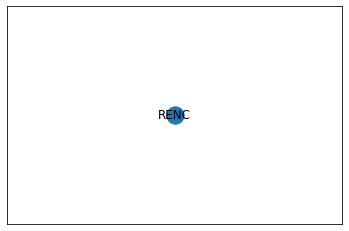

In [6]:
advertised_topology.draw()

## Create Slice

In [35]:
import fim.user as fu
# Create topology
t = fu.ExperimentTopology()

# Add node
n1 = t.add_node(name='n1', site='RENC')

# Set capacities
cap = fu.Capacities()
cap.set_fields(core=4, ram=64, disk=500)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_8')

# Add PCI devices
n1.add_component(ctype=fu.ComponentType.SmartNIC, model='ConnectX-6', name='nic1')

# Add node
n2 = t.add_node(name='n2', site='RENC')

# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_8')

# Add PCI devices
n2.add_component(ctype=fu.ComponentType.GPU, model='Tesla T4', name='nic2')

# Generate Slice Graph
slice_graph = t.serialize()

ssh_key = None
with open ("/home/fabric/work/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = orchestrator_proxy.create(token=fabric_id_token, slice_name='JupyterSlice1', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
print("Reservations created {}".format(reservations))

Response Status Status.OK
Reservations created [{"graph_node_id": "fba024ba-32f4-4080-8b21-fcd228bac191", "join_state": "None_", "reservation_id": "68e01695-9e01-4e8c-8370-e4f6ec7b1d9e", "reservation_state": "Unknown", "resource_type": "VM", "slice_id": "b94b310c-5efe-411e-97ff-af121cce9a0b"}, {"graph_node_id": "d0f1fb25-6a7c-4613-bd9d-06bac0d39b93", "join_state": "None_", "reservation_id": "83e0d3dd-04a5-40cb-afd2-33bc947c1e6f", "reservation_state": "Unknown", "resource_type": "VM", "slice_id": "b94b310c-5efe-411e-97ff-af121cce9a0b"}]


In [36]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

## Query Slices

In [7]:
status, slices = orchestrator_proxy.slices(token=fabric_id_token)

print("Response Status {}".format(status))
print("Slices {}".format(slices))

Response Status Status.OK
Slices [{"graph_id": "1686a0ae-5dbe-4859-a912-b12f85b5a30e", "slice_id": "8229af73-c2f5-4407-9846-7ec25ec3ac46", "slice_name": "JupyterSlice1", "slice_state": "StableOK"}]


## Query Slice

In [38]:
status, slice_obj = orchestrator_proxy.get_slice(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(slice_obj))

Response Status Status.OK
Response received n1[VM]: { core: 4 ram: 64G disk: 500G }
n2[VM]: { core: 4 ram: 64G disk: 500G }



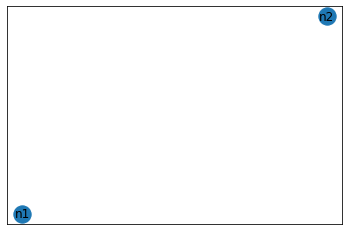

In [39]:
slice_obj.draw()

## Query Slivers

In [40]:
status, reservations = orchestrator_proxy.slivers(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Reservations {}".format(reservations))

Response Status Status.OK
Reservations [{"capacities": "{\"core\": 4, \"disk\": 500, \"ram\": 64}", "graph_node_id": "d0f1fb25-6a7c-4613-bd9d-06bac0d39b93", "join_state": "NoJoin", "labels": "", "management_ip": "152.54.15.48", "name": "n2", "reservation_id": "83e0d3dd-04a5-40cb-afd2-33bc947c1e6f", "reservation_state": "Active", "resource_type": "VM", "site": "RENC", "slice_id": "b94b310c-5efe-411e-97ff-af121cce9a0b"}, {"capacities": "{\"core\": 4, \"disk\": 500, \"ram\": 64}", "graph_node_id": "fba024ba-32f4-4080-8b21-fcd228bac191", "join_state": "NoJoin", "labels": "", "management_ip": "152.54.15.41", "name": "n1", "reservation_id": "68e01695-9e01-4e8c-8370-e4f6ec7b1d9e", "reservation_state": "Active", "resource_type": "VM", "site": "RENC", "slice_id": "b94b310c-5efe-411e-97ff-af121cce9a0b"}]


In [41]:
# Set the Sliver ID from output of the above command by capturing reservation_id
sliver_id=reservations[0].reservation_id

## Query Sliver

In [42]:
status, reservation = orchestrator_proxy.slivers(token=fabric_id_token, slice_id=slice_id, sliver_id=sliver_id)

print("Response Status {}".format(status))
print("Reservation {}".format(reservation))

Response Status Status.OK
Reservation [{"capacities": "{\"core\": 4, \"disk\": 500, \"ram\": 64}", "graph_node_id": "d0f1fb25-6a7c-4613-bd9d-06bac0d39b93", "join_state": "NoJoin", "labels": "", "management_ip": "152.54.15.48", "name": "n2", "reservation_id": "83e0d3dd-04a5-40cb-afd2-33bc947c1e6f", "reservation_state": "Active", "resource_type": "VM", "site": "RENC", "slice_id": "b94b310c-5efe-411e-97ff-af121cce9a0b"}]


## Slice Status

In [43]:
status, slice_status = orchestrator_proxy.slice_status(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Slice Status {}".format(slice_status))

Response Status Status.OK
Slice Status {"graph_id": "8c52b2e8-3de2-45ca-abc5-ce5318ff1659", "slice_id": "b94b310c-5efe-411e-97ff-af121cce9a0b", "slice_name": "JupyterSlice1", "slice_state": "StableOK"}


## Sliver Status

In [44]:
status, reservation_status = orchestrator_proxy.sliver_status(token=fabric_id_token, slice_id=slice_id, sliver_id=sliver_id)

print("Response Status {}".format(status))
print("Reservation Status {}".format(reservation_status))

Response Status Status.OK
Reservation Status {"capacities": "{\"core\": 4, \"disk\": 500, \"ram\": 64}", "graph_node_id": "d0f1fb25-6a7c-4613-bd9d-06bac0d39b93", "join_state": "NoJoin", "labels": "", "management_ip": "152.54.15.48", "name": "n2", "notices": "Reservation 83e0d3dd-04a5-40cb-afd2-33bc947c1e6f (Slice JupyterSlice1(b94b310c-5efe-411e-97ff-af121cce9a0b) Graph Id:8c52b2e8-3de2-45ca-abc5-ce5318ff1659 ) is in state [Active,None_]\n\nLast ticket update: \nTicket events: \nLast ticket update: \nTicket events: ", "reservation_id": "83e0d3dd-04a5-40cb-afd2-33bc947c1e6f", "reservation_state": "Active", "resource_type": "VM", "site": "RENC", "slice_id": "b94b310c-5efe-411e-97ff-af121cce9a0b"}


## Delete Slice

In [45]:
status, result = orchestrator_proxy.delete(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(result))

Response Status Status.OK
Response received {'value': None}
